In [2]:
# libraries
import os
import re
import subprocess 
import numpy as np
import pandas as pd
from scipy import io, signal
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
# for ripple detection
import ripple_detection
from ripple_detection.simulate import simulate_time
from scipy import signal
import seaborn as sns
#import KernelRegDraft as kreg # custom module, not needed
#import 'Stienmetz2019Reanalyzed/KernelRegDraft.py' as kreg
import piso #can be difficult to install, https://piso.readthedocs.io/en/latest/
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import tqdm
import piso
from ripple_detection.simulate import simulate_time
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import xarray as xr


In [3]:
# setting paths
# change this as needed:
sdk_cache_dir='/space/scratch/allen_visbehave_data'# path to where the cache for the allensdk is (wehre the lfp is going)
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
input_dir_buszaki = '/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_data_buszaki_test'
input_dir_mine = '/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_data_debug'
output_dir = os.path.curdir

In [4]:
# Functions

def check_overlap(df1, df2, offset=0):
    # returns true or false if there is overlap between the two dataframes with start_time and end_time columns
    result = []

    for i in range(len(df1)):
        start_time_1, end_time_1 = df1.loc[i, 'start_time'] - offset, df1.loc[i, 'end_time'] + offset
        overlap = any((start_time_2 < end_time_1 and end_time_2 > start_time_1) for start_time_2, end_time_2 in zip(df2['start_time'], df2['end_time']))
        result.append(overlap)

    return result


def merge_intervals(intervals, x_offset=0):
    """
    Merges overlapping intervals within a list of intervals
    Convert intervals into sets of tuples then merge with this function
    
    parameters
    intervals : list of tuples
    x_offset : int, optional, time offset to merge intervals
    
    Returns a list of merged intervals
    """
    intervals.sort(key=lambda interval: interval[0])

    stack = [intervals[0]]
    for current in intervals[1:]:
        last = stack[-1]
        if current[0] <= last[1] + x_offset:
            stack[-1] = (last[0], max(last[1], current[1]))
        else:
            stack.append(current)
    
    return stack

# Function to convert DataFrame to set of tuples (start_time, end_time)
def dataframe_to_interval_set(df):
    interval_set = set()
    for index, row in df.iterrows():
        interval_set.add((row['start_time'], row['end_time']))
    return interval_set

def union_of_lists_of_interval_sets(list_of_interval_sets):
    """
    Takes a list of lists of interval sets and returns the union of all
    interval sets in the list
    
    parameters
    list_of_interval_sets : list of lists of interval sets
    
    Returns a list of merged intervals
    """
    union = set()
    for interval_set in list_of_interval_sets:
        union = union.union(interval_set)
    return union


def union_of_event_times(list_of_event_intervals_df, offset=0):
    """
    Returns the union of all event times in a list of DataFrames
    Parameters
    ----------
    list_of_event_intervals_df : list of DataFrames
        Each DataFrame should have columns 'start_time' and 'end_time'
    offset : int, optional, time offset to merge intervals
    Returns
    -------     
    list : list of tuples
        Each tuple is an event time interval
    """
    set_list = []
    for df in list_of_event_intervals_df:
        set_list.append(dataframe_to_interval_set(df))
    
    union = union_of_lists_of_interval_sets(set_list)
    
    return merge_intervals(list(union), x_offset=offset)

def dataframe_union_of_event_times(list_of_event_intervals_df, offset=0, event_name='event'):
    """
    Returns the union of all event times in a list of DataFrames
    Parameters
    ----------
    list_of_event_intervals_df : list of DataFrames
        Each DataFrame should have columns 'start_time' and 'end_time'
    offset : int, optional, time offset to merge intervals
    Returns
    -------     
    DataFrame : DataFrame of event times
        Columns are 'start_time' and 'end_time'
    """
    union = union_of_event_times(list_of_event_intervals_df, offset=offset)
    union_df = pd.DataFrame(union, columns=['start_time', 'end_time'])
    union_df[event_name] = union_df.index
    return union_df

def add_overlap_probes(df, df_dict, overlap_col_name='overlap_probes'):
    """
    Adds a column to a DataFrame that lists the probes that overlap with putative global event created from
    the union of the DataFrames in df_dict
    Parameters
    ----------
    df : DataFrame
        DataFrame with columns 'start_time' and 'end_time'
    df_dict : dict
        Dictionary of DataFrames with columns 'start_time' and 'end_time'
    overlap_col_name : str, optional, name of column to add to df
    Returns
    -------
    DataFrame : DataFrame with new column 'overlap_probes'
    """
    overlap_probes = []
    for i, row in df.iterrows():
        overlap_probes_row = []
        for key, df_probe in df_dict.items():
            overlap = any((df_probe['start_time'] < row['end_time']) & (df_probe['end_time'] > row['start_time']))
            if overlap:
                overlap_probes_row.append(key)
        overlap_probes.append(overlap_probes_row)
    df[overlap_col_name] = overlap_probes
    return df

def find_channel_num_in_filename(unfilterd_swr_path, criteria1, criteria2):
    """
    Finds the channel number in the filename of the unfiltered swr file
    Parameters
    ----------
    unfilterd_swr_path : str
        Path to the unfiltered swr file (e.g. '/space/scratch/allen_visbehave_swr_data_test/filtered_lfp/filtered_lfp_0.mat')
    criteria1 : str 
        Criteria to find in the filename (e.g. 'filtered_lfp')
    criteria2 : str
        Criteria to find in the filename (e.g. 'channel')
    Returns
    -------
    int : channel number
    """
    filenames = np.array(os.listdir(unfilterd_swr_path))
    mask = np.array([], dtype=bool)
    for filename in filenames:
        if criteria1 in filename and criteria2 in filename:
            mask = np.append(mask,True)
        else:
            mask = np.append(mask,False)
    filename = str(filenames[mask])
    start = filename.find('channel_') + len('channel_')
    end = filename.find('_', start)
    result = filename[start:end] if start != -1 and end != -1 else None
    return int(result)

def find_probe_filename(unfiltered_swr_path, criteria1, criteria2):
    """
    Finds the channel number in the filename of the unfiltered swr file
    Parameters
    ----------
    unfilterd_swr_path : str
        Path to the unfiltered swr file (e.g. '/space/scratch/allen_visbehave_swr_data_test/filtered_lfp/filtered_lfp_0.mat')
    criteria1 : str 
        Criteria to find in the filename (e.g. 'filtered_lfp')
    criteria2 : str
        Criteria to find in the filename (e.g. 'channel')
    Returns
    -------
    int : channel number
    """

    filenames = np.array(os.listdir(unfiltered_swr_path))
    filenames2 = np.array([file for file in os.listdir(unfiltered_swr_path) if os.path.isfile(os.path.join(unfiltered_swr_path, file))])
    mask = np.array([], dtype=bool)
    for filename in filenames:
        if (criteria1 in filename) and (criteria2 in filename):
            mask = np.append(mask,True)
        else:
            mask = np.append(mask,False)
    filename = filenames[mask]
    return str(filename[0])

def unit_spike_times_alyx_format(session_obj, unit_ids, start_time=0, stop_time=np.inf, as_array=False):
    """
    Returns a DataFrame of spike times for multiple units in a session in the format
    according to the Alyx format
    
    Parameters
    ----------
    session : allensdk session object
    unit_ids : list of unit ids (obtained by session.units.index)
    start_time : float, optional, start time of spike times
    stop_time : float, optional, stop time of spike times
    as_array : bool, optional, if True returns a numpy array instead of a DataFrame
    
    Returns
    -------
    DataFrame or numpy array of spike times
    """
    df = pd.DataFrame(columns=['units', 'times'])

    for unit_id in unit_ids:
        ca1_unit_time = np.array(session_obj.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df = pd.concat([df, df_temp], ignore_index=True)

    df = df.sort_values(by='times')

    if as_array:
        return df.values
    else:
        return df
    
#For smoothing we make halfguassian_kernel1d and halfgaussian_filter1d
def halfgaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Half-Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(0, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

def halfgaussian_filter1d(input, sigma, axis=-1, output=None,
                      mode="constant", cval=0.0, truncate=4.0):
    """
    Convolves a 1-D Half-Gaussian convolution kernel.
    """
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = halfgaussian_kernel1d(sigma, lw)
    origin = -lw // 2
    return scipy.ndimage.convolve1d(input, weights, axis, output, mode, cval, origin)

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(LFP_array, samplingfreq, lowcut = 1, highcut = 250,
                    filter_order = 101):
    
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                              pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return(filtered_signal)



In [5]:

eventspersession_buszaki_df = pd.read_csv('/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_data_buszaki_test/filtered_swrs/eventspersession_df.csv', index_col=0)
# Convert 'probe_id' and 'session_id' to a category type
print(eventspersession_buszaki_df.head())
eventspersession_mine_df = pd.read_csv('/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_data_debug/filtered_swrs/eventspersession_df.csv', index_col=0)
# Convert 'probe_id' and 'session_id' to a category type
print(eventspersession_mine_df.head())


   session_id   probe_id  ripple_number
0   719161530  729445648             36
1   719161530  729445654              0
2   719161530  729445658             65
3   719161530  729445656              0
4   719161530  729445650             53
   session_id   probe_id  ripple_number
0   715093703  810755797             73
1   715093703  810755801             38
2   715093703  810755805              8
3   715093703  810755807             35
4   715093703  810755803             43


In [6]:
eventspersession_buszaki_df

,session_id,probe_id,ripple_number
0,719161530,729445648,36
1,719161530,729445654,0
2,719161530,729445658,65
3,719161530,729445656,0
4,719161530,729445650,53
5,721123822,760213137,7
6,721123822,760213142,30
7,721123822,760213147,14
8,721123822,760213150,0
9,721123822,760213153,25


In [7]:
session_list = [715093703, 719161530, 721123822] # for example
session_id = 715093703
session = cache.get_session_data(session_id)

running_speed_midpoints = session.running_speed
running_speed_midpoints

,start_time,end_time,velocity
0,13.41923,13.43465,23.570796
1,13.45141,13.46807,14.813276
2,13.46807,13.48474,14.352495
3,13.50135,13.51810,16.674026
4,13.51810,13.53475,16.747644
...,...,...,...
366031,9195.00420,9195.02088,0.540036
366032,9195.03746,9195.05443,1.681892
366033,9195.05443,9195.07118,-1.833893
366034,9195.08787,9195.10462,1.990784


In [8]:
!ls /space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_data_buszaki_test/filtered_swrs

eventspersession_df.csv  swrs_session_719161530
swrs_session_715093703	 swrs_session_721123822


In [9]:
# pulling probe events, for buszaki
probe_event_dict_buszaki = {}
filt_sesh_path = os.path.join(input_dir_buszaki, 'filtered_swrs')
probe_list = eventspersession_buszaki_df.probe_id[eventspersession_buszaki_df.session_id==session_id].unique()
for probe_id in probe_list:
    probepath = os.path.join(filt_sesh_path,'swrs_session_{}'.format(session_id))
    eventfilename = find_probe_filename(probepath, criteria1= 'probe_{}'.format(probe_id), criteria2= 'filtered_swrs')
    probe_event_dict_buszaki[probe_id] = pd.read_csv(os.path.join(probepath,eventfilename), index_col=0)


# pulling probe events, for my detector
session_id = session_list[0]
probe_event_dict_mine = {}
filt_sesh_path = os.path.join(input_dir_mine, 'filtered_swrs')
probe_list = eventspersession_mine_df.probe_id[eventspersession_mine_df.session_id==session_id].unique()
for probe_id in probe_list:
    probepath = os.path.join(filt_sesh_path,'swrs_session_{}'.format(session_id))
    eventfilename = find_probe_filename(probepath, criteria1= 'probe_{}'.format(probe_id), criteria2= 'filtered_swrs')
    probe_event_dict_mine[probe_id] = pd.read_csv(os.path.join(probepath,eventfilename), index_col=0)

In [10]:
# 729445658	
probe_id = 810755797
lfp = session.get_lfp(probe_id)
SAMPLING_FREQUENCY = session.probes.lfp_sampling_rate[probe_id]
unfilt_sesh_path = os.path.join(input_dir_buszaki, 'swrs_session_{}'.format(session_id))
channel_id = find_channel_num_in_filename(unfilt_sesh_path, criteria1='probe_'.format(probe_id), criteria2= 'karlsson_detector_events')
channel_id

850260279

In [11]:
this_chan = lfp.sel(channel=850264486)


In [12]:
probe_event_dict_mine.keys()

dict_keys([810755797, 810755801, 810755805, 810755807, 810755803])

In [13]:
ripples_mine_df = probe_event_dict_mine[probe_id]
highest_peaks_mine = ripples_mine_df['max_zscore'].nlargest(5).index
print(highest_peaks_mine)


ripples_buszaki_df =  probe_event_dict_buszaki[probe_id]
highest_buszaki_peaks = ripples_buszaki_df['max_zscore'].nlargest(5).index
print(highest_buszaki_peaks)


Int64Index([5, 10, 7, 61, 3], dtype='int64')
Int64Index([5, 47, 10, 7, 25], dtype='int64')


In [14]:
from ripple_detection import filter_ripple_band

raw_lfp_zscore = stats.zscore(this_chan.to_numpy())

#rip_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 150, highcut = 250, samplingfreq= SAMPLING_FREQUENCY)
rip_band = filter_ripple_band(this_chan.to_numpy()[:,None])
zscore_rip_power = stats.zscore(np.abs(rip_band)**2)

sharpwave_band = finitimpresp_filter_for_LFP(this_chan, lowcut = 8, highcut = 40, samplingfreq= SAMPLING_FREQUENCY)
zscore_sharpwave_power = stats.zscore(np.abs(sharpwave_band)**2)

gamma_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 20, highcut = 80, samplingfreq= SAMPLING_FREQUENCY)
zscore_gamma_power = stats.zscore(np.abs(gamma_band)**2)

theta_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 6, highcut = 10, samplingfreq= SAMPLING_FREQUENCY)
zscore_theta_power = stats.zscore(np.abs(theta_band)**2)

In [15]:
probe_event_dict_mine.keys()

dict_keys([810755797, 810755801, 810755805, 810755807, 810755803])

In [16]:
ripples_buszaki_df

,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed,Peak_Amplitude,Peak_Amplitude_lfpzscore,Peak_time,Overlaps_with_movement
0,15,194.212268,194.411468,0.1992,4.208330,4.893290,6.709725,0.021250,0.0,0.0,0.0,0.0,0.0,0.0,0.000846,NaN,194.319468,False
1,25,275.335601,275.485201,0.1496,2.996624,3.044621,5.568500,0.007511,0.0,0.0,0.0,0.0,0.0,0.0,0.000499,NaN,275.485201,False
2,35,341.093309,341.307710,0.2144,4.312821,5.149082,6.437512,0.050641,0.0,0.0,0.0,0.0,0.0,0.0,0.000994,NaN,341.224509,False
3,38,358.133337,358.374138,0.2408,2.888882,2.023768,7.237924,0.004499,0.0,0.0,0.0,0.0,0.0,0.0,0.000653,NaN,358.212537,False
4,42,398.654204,398.900604,0.2464,2.749445,2.342630,6.013417,0.003839,0.0,0.0,0.0,0.0,0.0,0.0,0.000712,NaN,398.750204,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,253,8938.937475,8939.177476,0.2400,2.325697,1.886050,5.202169,0.003479,0.0,0.0,0.0,0.0,0.0,0.0,0.000594,NaN,8938.983075,False
78,254,8940.176677,8940.390277,0.2136,2.992791,2.791388,5.768609,0.036604,0.0,0.0,0.0,0.0,0.0,0.0,0.000554,NaN,8940.271877,False
79,260,9130.360963,9130.580964,0.2200,2.647404,2.169127,5.574351,0.013951,0.0,0.0,0.0,0.0,0.0,0.0,0.000807,NaN,9130.499364,False
80,263,9146.420988,9146.661788,0.2408,2.110133,1.459320,5.789450,0.009975,0.0,0.0,0.0,0.0,0.0,0.0,0.001043,NaN,9146.578588,False


0.2352003540072473


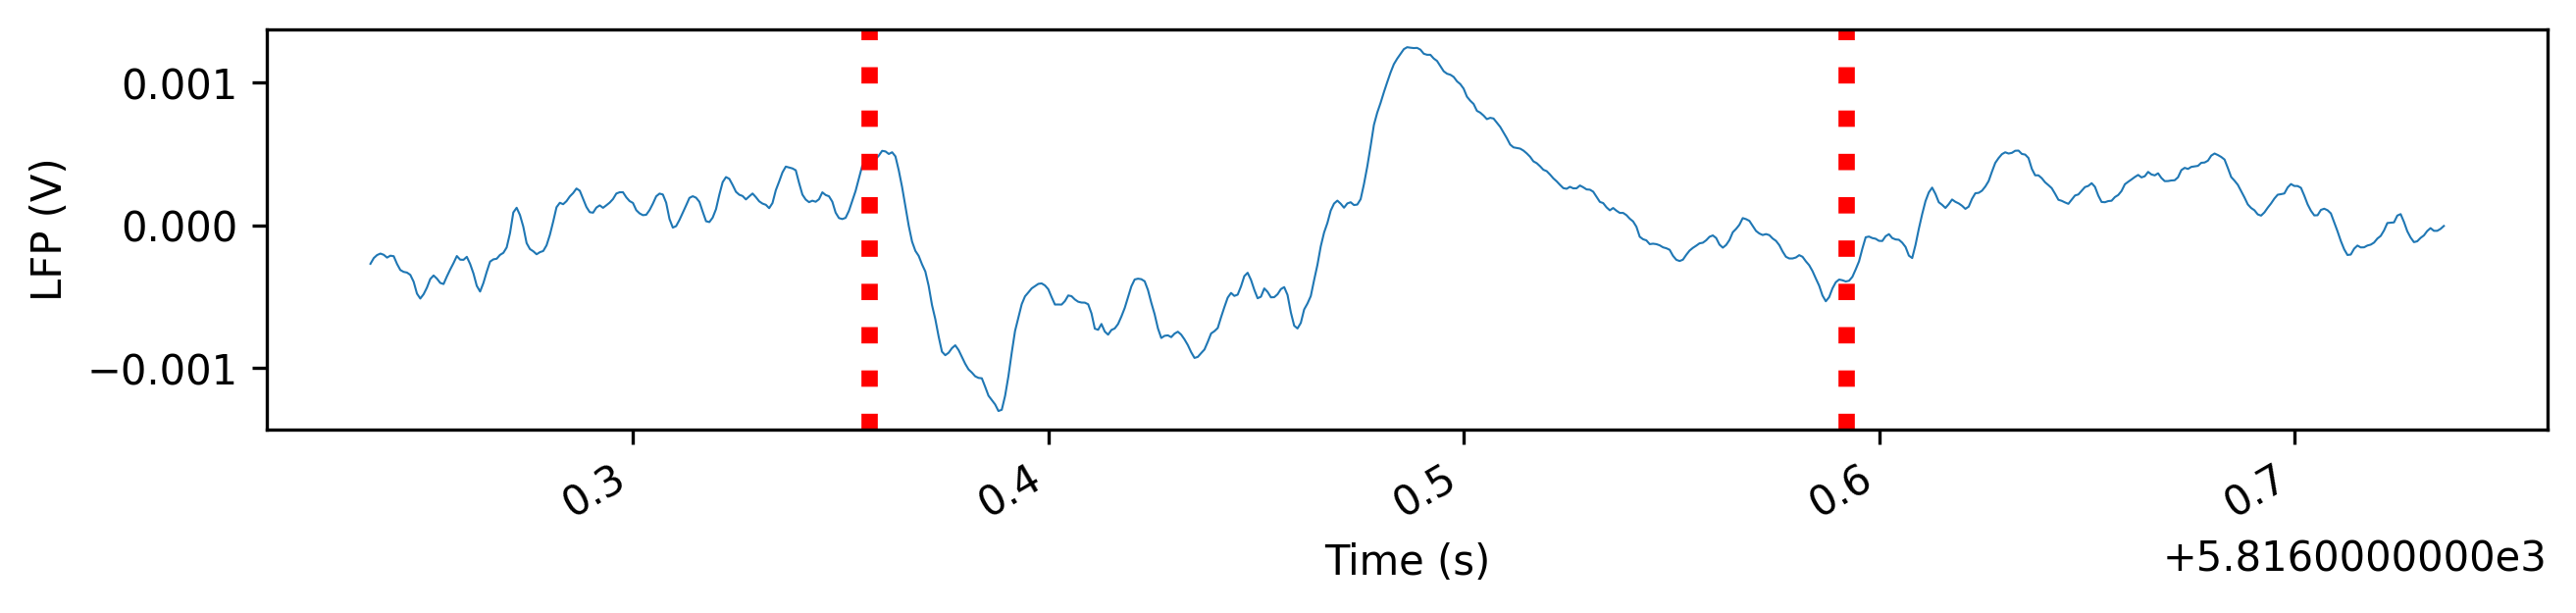

In [17]:

rip_num = highest_buszaki_peaks[1]
print(ripples_buszaki_df.duration[rip_num])
lasts = ripples_buszaki_df.duration[rip_num]
rip_offset = 0.25
rip_begin = ripples_buszaki_df.Peak_time[rip_num]-rip_offset
rip_end = ripples_buszaki_df.Peak_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_buszaki_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_buszaki_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

0.2272003729272


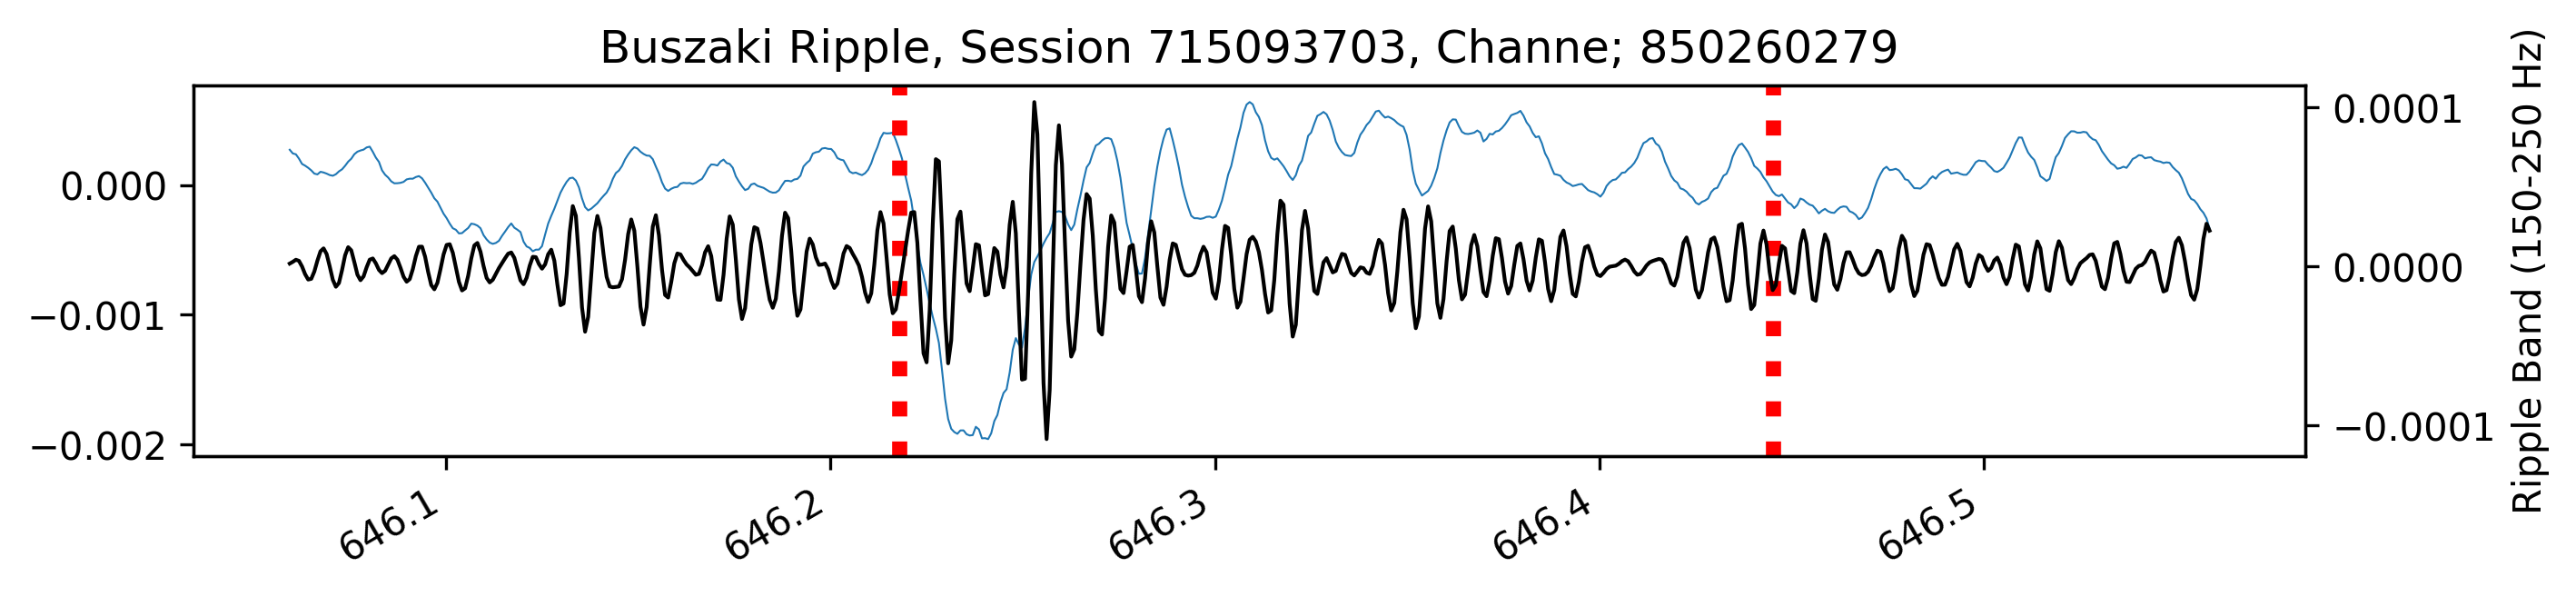

In [18]:
rip_num = highest_buszaki_peaks[2]
print(ripples_buszaki_df.duration[rip_num])
lasts = ripples_buszaki_df.duration[rip_num]
rip_offset = 0.25
rip_begin = ripples_buszaki_df.Peak_time[rip_num]-rip_offset
rip_end = ripples_buszaki_df.Peak_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

rip_band_slice = rip_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_buszaki_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_buszaki_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)

# Create a second y-axis and plot rip_band on it
ax2 = plt.gca().twinx()
_ = ax2.plot(this_chan_slice.time, rip_band_slice, 'black', linewidth=1)  # 'g-' makes the line green

# Set y-axis labels
plt.ylabel('LFP (V)')
ax2.set_ylabel('Ripple Band (150-250 Hz)', color='Black')

plt.xlabel('Time (s)')
# Add a title
plt.title('Buszaki Ripple, Session {}, Channe; {}'.format(session_id, channel_id))

plt.gcf().autofmt_xdate()

0.2352003540072473


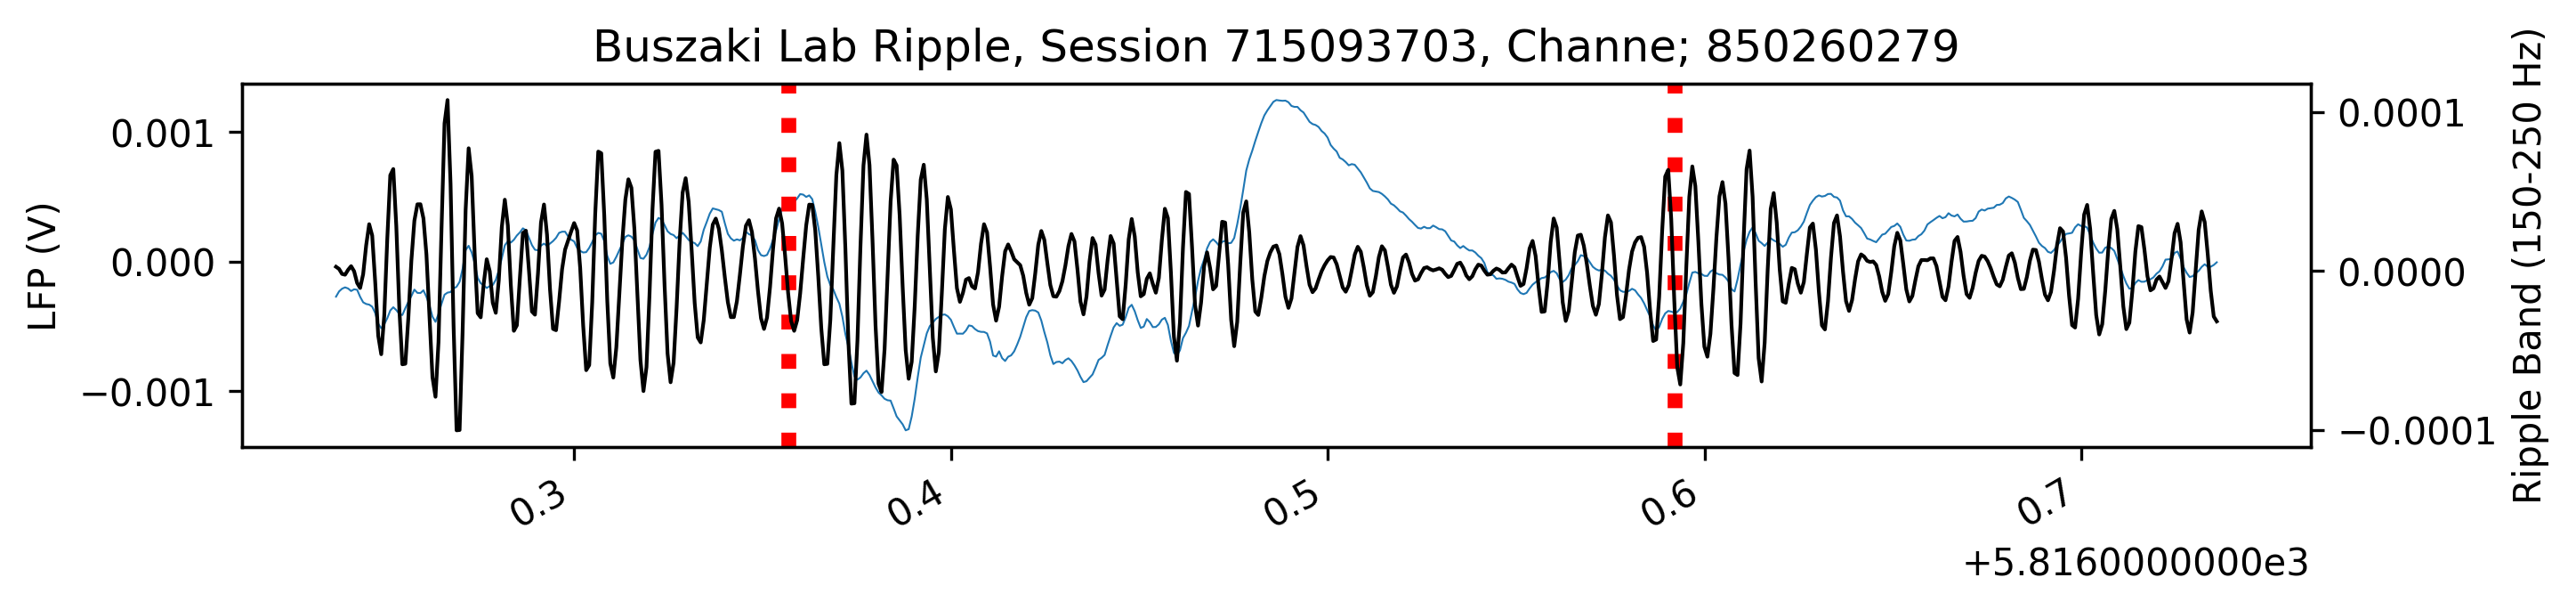

In [19]:
rip_num = highest_buszaki_peaks[1]
print(ripples_buszaki_df.duration[rip_num])
lasts = ripples_buszaki_df.duration[rip_num]
rip_offset = 0.25
rip_begin = ripples_buszaki_df.Peak_time[rip_num]-rip_offset
rip_end = ripples_buszaki_df.Peak_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

rip_band_slice = rip_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)

# Plot this_chan_slice and set y-axis label
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)
plt.ylabel('LFP (V)')

# Add red dotted lines
plt.axvline(x=ripples_buszaki_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_buszaki_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)

# Create a second y-axis, plot rip_band_slice on it and set y-axis label
ax2 = plt.gca().twinx()
_ = ax2.plot(this_chan_slice.time, rip_band_slice, 'black', linewidth=1)
ax2.set_ylabel('Ripple Band (150-250 Hz)', color='Black')

plt.xlabel('Time (s)')
plt.title('Buszaki Lab Ripple, Session {}, Channe; {}'.format(session_id, channel_id))

plt.gcf().autofmt_xdate()

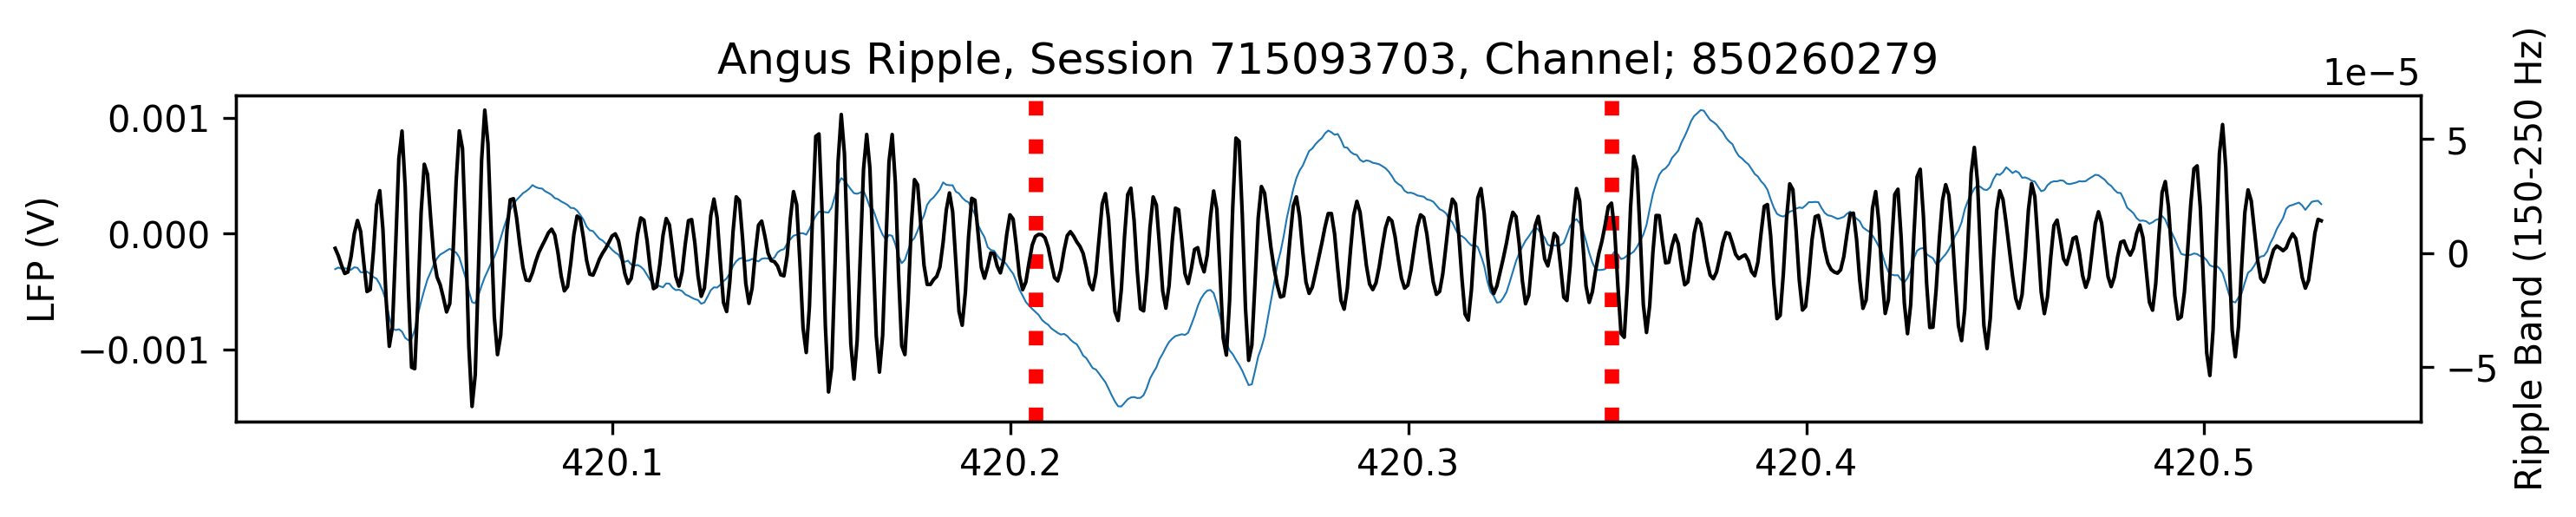

In [28]:
rip_num = highest_peaks_mine[0]

rip_offset = 0.25
rip_begin = ripples_mine_df.Peak_time[rip_num]-rip_offset
rip_end = ripples_mine_df.Peak_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

rip_band_slice = rip_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)

# Plot this_chan_slice and set y-axis label
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)
plt.ylabel('LFP (V)')

# Add red dotted lines
plt.axvline(x=ripples_mine_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_mine_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)

# Create a second y-axis, plot rip_band_slice on it and set y-axis label
ax2 = plt.gca().twinx()
_ = ax2.plot(this_chan_slice.time, rip_band_slice, 'black', linewidth=1)
ax2.set_ylabel('Ripple Band (150-250 Hz)', color='Black')

plt.xlabel('Time (s)')
# Add a title
plt.title('Angus Ripple, Session {}, Channel; {}'.format(session_id, channel_id))
plt.tight_layout()

0.2272003729272


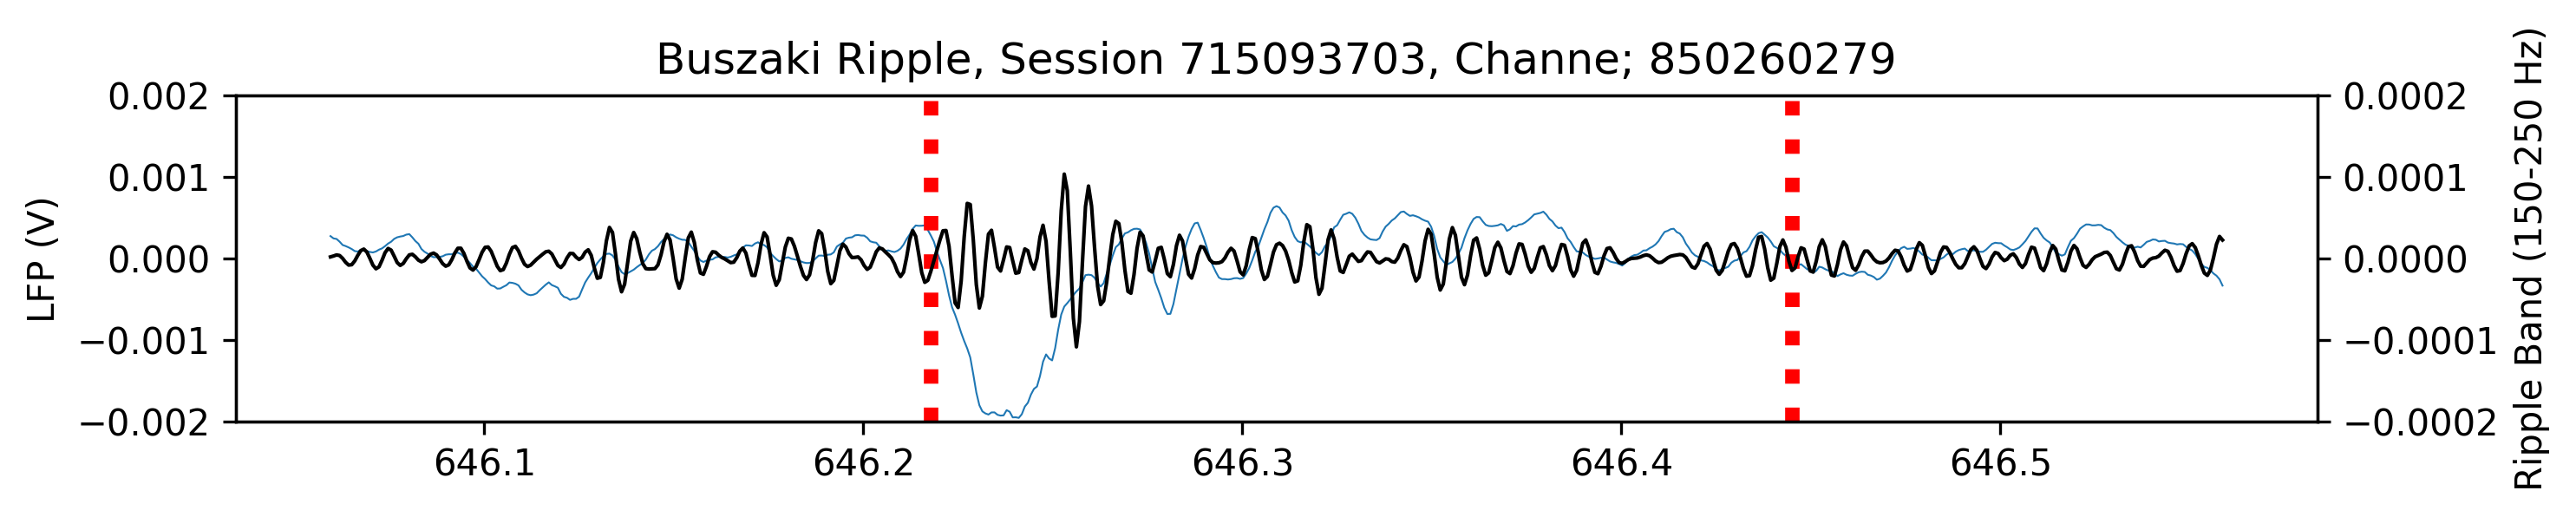

In [33]:
rip_num = highest_buszaki_peaks[2]
print(ripples_buszaki_df.duration[rip_num])
lasts = ripples_buszaki_df.duration[rip_num]
rip_offset = 0.25
rip_begin = ripples_buszaki_df.Peak_time[rip_num]-rip_offset
rip_end = ripples_buszaki_df.Peak_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

rip_band_slice = rip_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)

# Plot this_chan_slice and set y-axis label
ax1 = plt.gca()
_ = ax1.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)
ax1.set_ylabel('LFP (V)')

# Set y-axis limits for ax1
ax1.set_ylim([-0.002, 0.002])

# Add red dotted lines
plt.axvline(x=ripples_buszaki_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_buszaki_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)

# Create a second y-axis, plot rip_band_slice on it and set y-axis label
ax2 = plt.gca().twinx()
_ = ax2.plot(this_chan_slice.time, rip_band_slice, 'black', linewidth=1)
ax2.set_ylabel('Ripple Band (150-250 Hz)', color='Black')

# Set y-axis limits for ax2
ax2.set_ylim([-0.0002, 0.0002])

plt.xlabel('Time (s)')
# Add a title
plt.title('Buszaki Ripple, Session {}, Channe; {}'.format(session_id, channel_id))
plt.tight_layout()

In [22]:
running_speed_midpoints = session.running_speed
running_speed_midpoints

,start_time,end_time,velocity
0,13.41923,13.43465,23.570796
1,13.45141,13.46807,14.813276
2,13.46807,13.48474,14.352495
3,13.50135,13.51810,16.674026
4,13.51810,13.53475,16.747644
...,...,...,...
366031,9195.00420,9195.02088,0.540036
366032,9195.03746,9195.05443,1.681892
366033,9195.05443,9195.07118,-1.833893
366034,9195.08787,9195.10462,1.990784


In [23]:
running_speed_midpoints.shape

(366036, 3)

In [24]:
def get_velocity_func(time, running_speed_df):
    """
    Returns the velocity at a given time
    Parameters
    ----------
    time : float
        Time to get velocity
    running_speed_df : DataFrame
        DataFrame with columns 'start_times', 'end_times', and 'velocity'
    Returns
    -------
    float : velocity at time
    """
    mask = (running_speed_df['start_time'] <= time) & (running_speed_df['end_time'] >= time)
    if running_speed_df[mask].empty:
        return time
    else:
        return running_speed_df.loc[mask, 'velocity'].values[0]

def get_velocity(time, running_speed_df):
    """
    Returns the velocity at a given time as a 1dnumpy array interpolated from a DataFrame with start end times of running speed measurements
    Parameters
    ----------
    time : float
        Time to get velocity
    running_speed_df : DataFrame
        DataFrame with columns 'start_times', 'end_times', and 'velocity'
    Returns
    -------
    float : velocity at time    
    """
    get_velocity_vectorized = np.vectorize(get_velocity_func, excluded=['running_speed_df'])
    return get_velocity_vectorized(time, running_speed_df=running_speed_df)

speed_vec = get_velocity(this_chan.time, running_speed_midpoints)
speed_vec.shape



KeyboardInterrupt: 

In [ ]:
running_speed_midpoints = session.running_speed["start_time"] + \
    (session.running_speed["end_time"] - session.running_speed["start_time"]) / 2
plot_running_speed(
    running_speed_midpoints, 
    session.running_speed["velocity"], 
    start_index=5000,
    stop_index=5100
)
plt.show()